# Implementation of SVM

Support Vector Machine (SVMs) are supervised machine learning algorithms that classify data by finding an optimat line (or hyperplane) that maximses the distance betweeneach class in an N-dimensional space.

## Install required packages

In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

## Imports

Import any packages required for this project.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from IPython.display import display

## Variables

Variables required throughout the whole notebook.

In [3]:
data_folder = "../../../data"
final_data_folder = f"{data_folder}/final"

data_csv = f"{final_data_folder}/data.csv"

## Explanation of notebook structure

1. First, we will perform some initial data exploratory analysis.
2. Then, we will attempt to implement an SVM using sklearn.

## Exploratory Data Analysis (EDA)

Perform a little bit of exploratory data analysis.

In [4]:
df = pd.read_csv(data_csv)

print(f"Dataset shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Dataset info:")
display(df.info())

Dataset shape: (219, 54)
Column names: ['id', 'date_published', 'accident_datetime', 'accident_severity', 'total_injured', 'city', 'street', 'accident_time_category', 'driver_under_18', 'driver_18_to_24', 'driver_25_to_49', 'driver_50_to_64', 'driver_65_plus', 'driver_age_unknown', 'num_drivers_under_18', 'num_drivers_18_to_24', 'num_drivers_25_to_49', 'num_drivers_50_to_64', 'num_drivers_65_plus', 'num_drivers_age_unknown', 'driver_male', 'driver_female', 'driver_gender_unknown', 'num_drivers_male', 'num_drivers_female', 'num_drivers_gender_unknown', 'num_drivers_total', 'vehicle_unknown', 'vehicle_pedestrian', 'vehicle_bicycle', 'vehicle_motorbike', 'vehicle_car', 'vehicle_van', 'vehicle_bus', 'num_vehicle_unknown', 'num_vehicle_pedestrian', 'num_vehicle_bicycle', 'num_vehicle_motorbike', 'num_vehicle_car', 'num_vehicle_van', 'num_vehicle_bus', 'is_weekend', 'is_public_holiday_mt', 'is_school_holiday_mt', 'is_school_day_mt', 'street_type', 'region', 'temperature_max', 'temperature_mi

None

### Outliers

Data collection happened between 2024-2025. However, we noticed some news articles report accidents that have happened some years back. These accidents could have happened under different conditions (different road conditions, traffic situations, etcetera) so we consider these accidents as outliers and will filter them out.

Accidents by Year:


accident_datetime
2006      1
2017      1
2018      1
2020      1
2022      2
2023      2
2024     23
2025    188
Name: count, dtype: int64

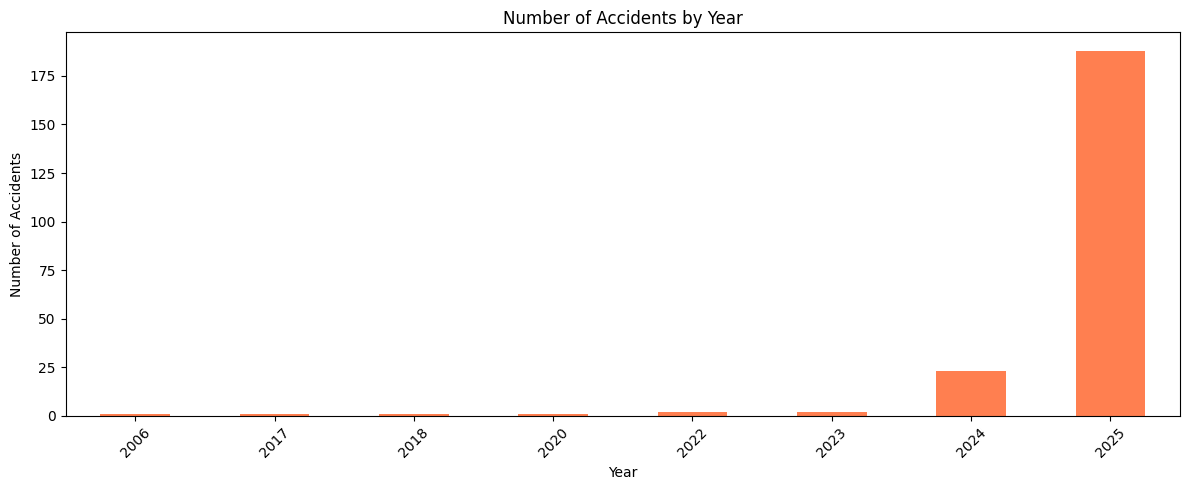

In [5]:
df["accident_datetime"] = pd.to_datetime(df["accident_datetime"])

accidents_by_year = df["accident_datetime"].dt.year.value_counts().sort_index()

print("Accidents by Year:")
display(accidents_by_year)

plt.figure(figsize=(12, 5))
accidents_by_year.plot(kind='bar', color='coral')
plt.title('Number of Accidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's filter out accidents that happened before 2024.

In [6]:
count_before = len(df)
df = df[df["accident_datetime"] >= "2024-01-01"]
count_after = len(df)

print(f"Removed {count_before - count_after} outliers")
print(f"Dataset shape after removing outliers: {df.shape}")

Removed 8 outliers
Dataset shape after removing outliers: (211, 54)


### Distribution of `accident_severity` column

In [7]:
severity_counts = df["accident_severity"].value_counts()

print(severity_counts)

accident_severity
grievious      85
serious        74
fatal          28
not injured    17
slight          7
Name: count, dtype: int64


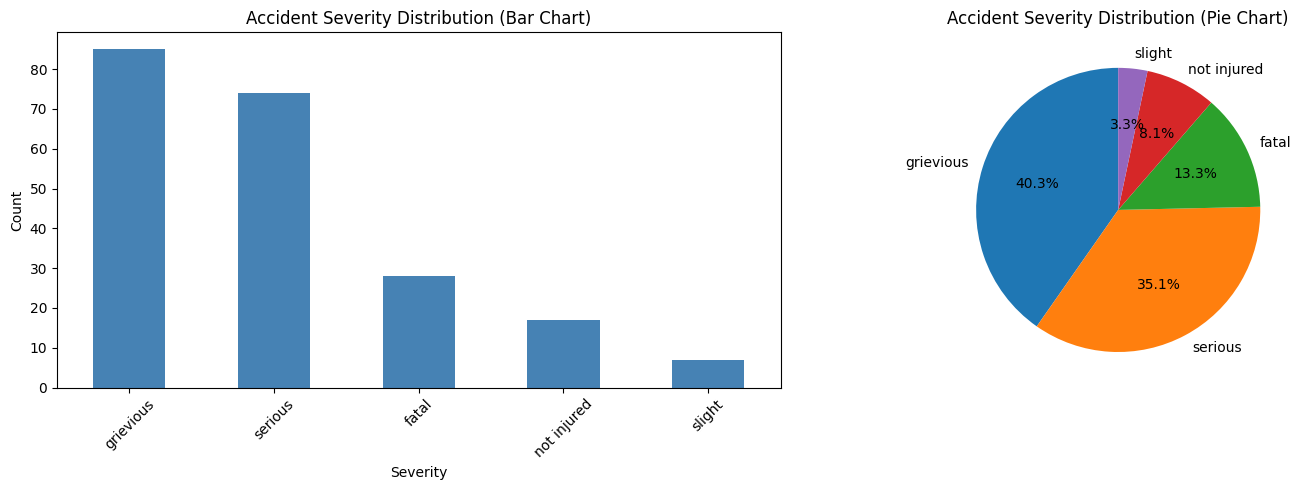

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# bar plot
severity_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Accident Severity Distribution (Bar Chart)')
axes[0].set_xlabel('Severity')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# pie chart
axes[1].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Accident Severity Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

The distribution of the `accident_severity` target variable is highly imbalanced, with certain classes containing very few samples. Given the limited dataset size (219 instances), this results in insufficient per-class representation for reliable multi-class learning.

To tackle this issue, the problem is reformulated as a binary classification task, grouping low-severity accidents (`not injured`, `slight`) and high-severity accidents (`grievous`, `serious`, `fatal`). This simplification trades severity granularity for improved learnability and model stability. A plausible contributing factor to the observed class imbalance is reporting bias, as minor accidents are less likely to be documented in news or official press releases.

In [9]:
low_severity = {"not injured", "slight"}
high_severity = {"grievous", "serious", "fatal"}

df["summarised_severity"] = df["accident_severity"].map(lambda x: "low" if x in low_severity else "high")
df["target_severity"] = df["accident_severity"].map(lambda x: 0 if x in low_severity else 1)

summarised_severity_counts = df["summarised_severity"].value_counts()
print(summarised_severity_counts)

print(f"Dataset info:")
display(df.info())

summarised_severity
high    187
low      24
Name: count, dtype: int64
Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 211 entries, 8 to 218
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          211 non-null    object        
 1   date_published              211 non-null    object        
 2   accident_datetime           211 non-null    datetime64[ns]
 3   accident_severity           211 non-null    object        
 4   total_injured               211 non-null    int64         
 5   city                        211 non-null    object        
 6   street                      211 non-null    object        
 7   accident_time_category      211 non-null    object        
 8   driver_under_18             211 non-null    bool          
 9   driver_18_to_24             211 non-null    bool          
 10  driver_25_to_49             211 non-null   

None

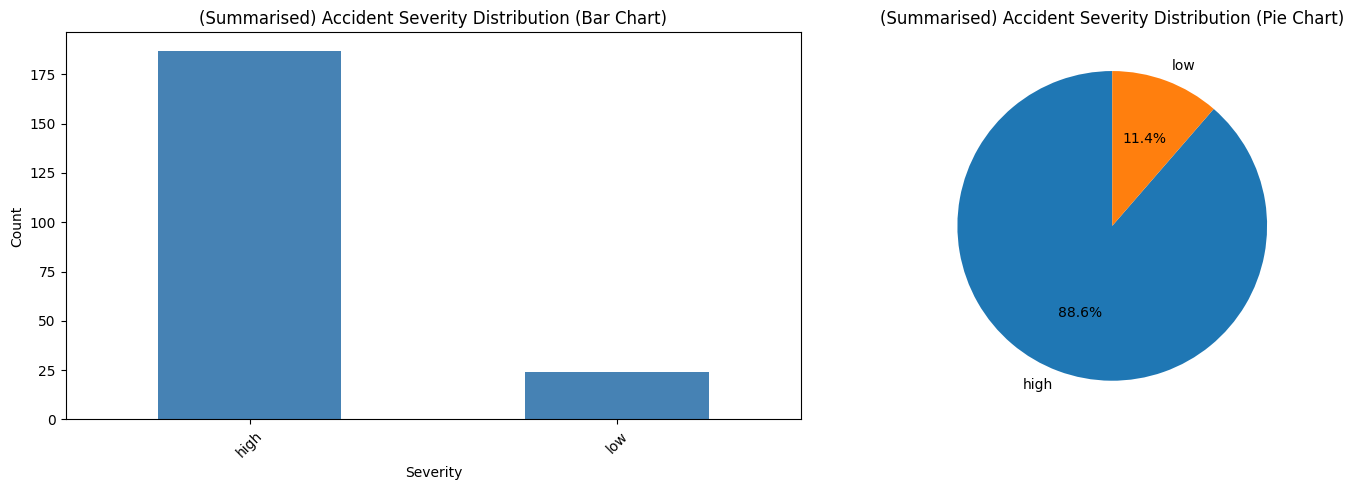

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# bar plot
summarised_severity_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('(Summarised) Accident Severity Distribution (Bar Chart)')
axes[0].set_xlabel('Severity')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# pie chart
axes[1].pie(summarised_severity_counts.values, labels=summarised_severity_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('(Summarised) Accident Severity Distribution (Pie Chart)')

plt.tight_layout()
plt.show()

### Investigate unknown booleans

Let's investigate the columns representing the unknowns, mainly `driver_age_unknown`, `driver_gender_unknown`, and `vehicle_unknown`.



Summary of unknowns:
  summarised_severity  driver_age_unknown  driver_gender_unknown  \
0                high                  16                     27   
1                 low                  18                     15   

   vehicle_unknown  
0                2  
1                0  


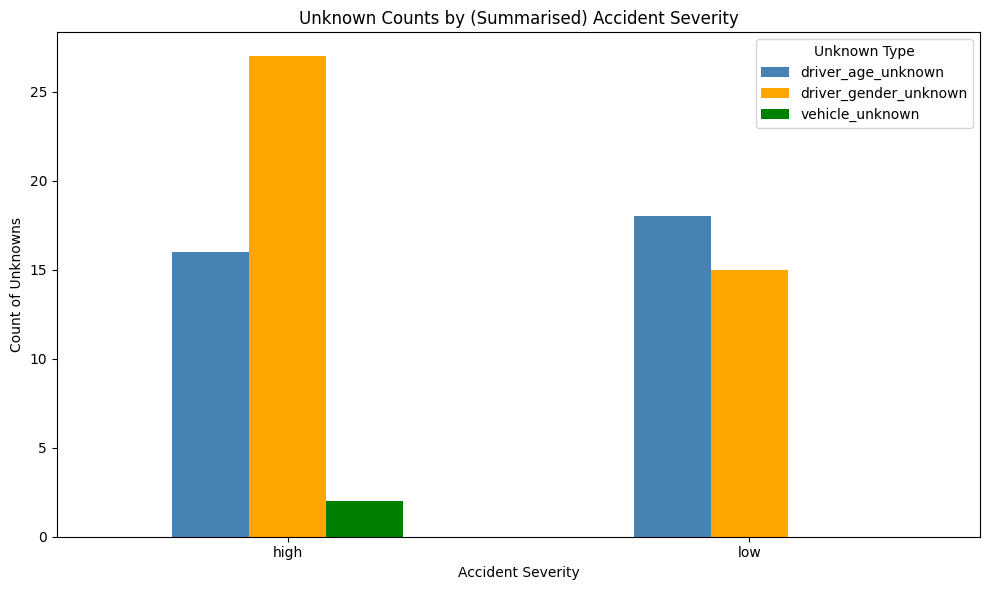

In [11]:
unknown_cols = [
    'driver_age_unknown', 
    'driver_gender_unknown', 
    'vehicle_unknown'
]

unknown_summary = df.groupby('summarised_severity')[unknown_cols].sum().reset_index()

print("Summary of unknowns:")
print(unknown_summary)

# plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for each unknown column
unknown_summary.plot(
    x='summarised_severity', 
    y=unknown_cols, 
    kind='bar', 
    ax=ax,
    color=['steelblue', 'orange', 'green']
)

ax.set_title('Unknown Counts by (Summarised) Accident Severity')
ax.set_ylabel('Count of Unknowns')
ax.set_xlabel('Accident Severity')
ax.legend(title='Unknown Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## SVM Training

Let's train an SVM using three different feature sets.

### Feature Set 1 (Excludes driver/vehicle features)

Focuses more on features related to the accident, such as temperature, road conditions, etcetera.

In [55]:
#numeric_features = ["temperature_mean", "windspeed_max"]
#categorical_features = ["accident_time_category", "street_type", "region", "traffic_level"]
#boolean_features = ["is_weekend", "is_public_holiday_mt", "is_school_day_mt", "is_raining"]

numeric_features = ["windspeed_max"]
categorical_features = ["region"]
boolean_features = ["is_weekend"]

feature_set_one = df[
    numeric_features
    +
    categorical_features
    +
    boolean_features
    +
    ["target_severity"]
]

X = feature_set_one[numeric_features + categorical_features + boolean_features]
y = feature_set_one['target_severity']  # target column

In [56]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),                     # Scale numeric features
        ('cat', OneHotEncoder(drop='first'), categorical_features),  # One-hot encode categories
        ('bool', 'passthrough', boolean_features)                        # Keep booleans as-is
    ]
)

# fit the transformer on the entire dataset (can also fit on train only after splitting)
X_prepared = preprocessor.fit_transform(X)

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names) + boolean_features

# Convert to DataFrame for easier inspection
X_prepared_df = pd.DataFrame(X_prepared, columns=all_feature_names)

# Train/test split (stratified because your target is imbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared_df,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Inspect shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_test distribution:\n", y_test.value_counts())

X_train shape: (168, 6)
X_test shape: (43, 6)
y_train distribution:
 target_severity
1    149
0     19
Name: count, dtype: int64
y_test distribution:
 target_severity
1    38
0     5
Name: count, dtype: int64


In [58]:
display(X_train)
display(X_test)
display(y_train)
display(y_test)

,windspeed_max,region_Gozo,region_Northern,region_South Eastern,region_Southern Harbour,is_weekend
119,-1.166819,0.0,0.0,0.0,1.0,0.0
21,0.355714,0.0,0.0,1.0,0.0,0.0
61,0.450216,0.0,0.0,0.0,0.0,0.0
30,0.786223,0.0,1.0,0.0,0.0,0.0
141,1.279734,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...
166,-1.082817,0.0,1.0,0.0,0.0,0.0
39,1.006728,0.0,0.0,0.0,1.0,1.0
160,-0.862313,0.0,0.0,0.0,0.0,1.0
197,0.418715,1.0,0.0,0.0,0.0,0.0


,windspeed_max,region_Gozo,region_Northern,region_South Eastern,region_Southern Harbour,is_weekend
22,-0.757310,0.0,0.0,0.0,1.0,1.0
147,0.072208,0.0,0.0,0.0,0.0,0.0
57,-1.271822,0.0,0.0,0.0,0.0,0.0
4,-1.103818,0.0,1.0,0.0,0.0,0.0
185,-1.040817,0.0,0.0,0.0,0.0,1.0
143,0.450216,0.0,0.0,0.0,1.0,0.0
90,-0.116796,0.0,0.0,0.0,0.0,0.0
82,0.061708,0.0,0.0,0.0,1.0,0.0
118,-0.904314,0.0,0.0,0.0,0.0,0.0
92,-0.148297,0.0,1.0,0.0,0.0,0.0


127    0
29     1
69     1
38     1
149    1
      ..
174    1
47     1
168    1
205    1
135    1
Name: target_severity, Length: 168, dtype: int64

30     1
155    1
65     1
12     1
193    1
151    1
98     1
90     1
126    1
100    0
131    1
152    1
34     1
68     0
33     1
48     1
122    1
202    1
26     1
150    1
108    1
64     1
67     1
20     1
102    1
197    1
75     1
214    1
180    0
63     1
206    1
21     1
81     1
107    1
195    0
51     0
194    1
70     1
27     1
110    1
154    1
74     1
77     1
Name: target_severity, dtype: int64

In [60]:
clf = SVC(C=10, kernel="linear", degree=3, gamma="auto")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"The performance of the SVM is: {acc}")

The performance of the SVM is: 0.8837209302325582
